### Bibliotecas

In [ ]:
import torch    
import os  
import numpy                as np
import pandas               as pd
import torch.nn.functional  as F
import matplotlib.pyplot    as plt
import seaborn              as sns
import plotly.graph_objects as go
import plotly.express       as px

from PIL                         import Image
from torch                       import nn, optim
from torch.nn.modules            import padding
from torch.nn.modules.activation import ReLU
from torchvision                 import datasets, transforms as T
from plotly.subplots             import make_subplots
from google.colab                import drive

print("Versão:",torch.__version__)

Versão: 1.10.0+cu111


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
batch_size = 24
epochs = 210
categorias = ['Glioma','Meningioma','Hipófise','Saudável']

transform_treino = T.Compose(
    [
     T.Resize([128,128]),
     T.ToTensor(),
    ]
)

transform_teste = T.Compose(
    [
     T.Resize([128,128]),
     T.ToTensor(),
    ]
)

In [ ]:
path_treino = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Treino_THRESOULD_INV'
path_teste = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Teste_THRESHOULD_INV'

In [ ]:
dataset_treino = datasets.ImageFolder(path_treino, transform=transform_treino)
loader_treino = torch.utils.data.DataLoader(dataset_treino, batch_size=batch_size, shuffle=True)

In [ ]:
dataset_teste = datasets.ImageFolder(path_teste, transform=transform_teste)
loader_teste = torch.utils.data.DataLoader(dataset_teste, batch_size=batch_size, shuffle=False)

In [ ]:
def base_de_dados(dataset):
  quantidade = {k: 0 for k, v in dataset.class_to_idx.items()}
  for i in dataset:
    rotulos = i[1]
    rotulos = indice_por_classe[rotulos]
    quantidade[rotulos] += 1
  return quantidade

indice_por_classe = {v: k for k, v in dataset_treino.class_to_idx.items()}
df_treino = pd.DataFrame.from_dict([base_de_dados(dataset_treino)]).melt()

indice_por_classe = {v: k for k, v in dataset_teste.class_to_idx.items()}
df_teste = pd.DataFrame.from_dict([base_de_dados(dataset_teste)]).melt()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(
    labels=df_treino['variable'],
     values=df_treino['value'],
      pull=[0, 0, 0.1, 0]),
       1, 1)

fig.add_trace(go.Pie(
    labels=df_teste['variable'],
     values=df_teste['value'],
      pull=[0, 0, 0.1, 0]),
       1, 2)

fig.update_traces(hole=.4,
    hoverinfo='label+percent',
                  textinfo='value',
                  textfont_size=12.5,
                  marker=dict(
                      line=dict(
                          color='#000000',
                           width=1)
                      )
                  )

fig.show()

In [ ]:
class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.convs = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p = 0.1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p = 0.2),
    )

    self.layers = nn.Sequential(
        nn.Linear(in_features=32768, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=4),
    )

    self.flatten = nn.Flatten()

    self.softmax = nn.Softmax()

  def forward(self, X):
    X = self.convs(X)
    X = self.flatten(X)
    X = self.layers(X)
    output = self.softmax(X)
    return output

In [ ]:
model = classificador()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001, momentum=0.3)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device,"\n")

model.to(device)

cuda 



classificador(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
  )
  (layers): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=None)
)

In [ ]:
def train(model, dataLoader, criterion, optimizer):
  model.train()
  cumloss = 0.0
  for imagens, rotulos in dataLoader:

    imagens, rotulos = imagens.to(device), rotulos.to(device)

    pred = model(imagens)
    loss = criterion(pred, rotulos)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss/len(dataLoader)

In [ ]:
def validacao(model, dataLoader, lossfunc):
    model.eval()
    cumloss = 0.0
    
    with torch.no_grad():
        for imgs, labels in dataLoader:
            
            imgs, labels = imgs.to(device), labels.to(device)
            
            pred = model(imgs)
            
            loss = lossfunc(pred, labels)
            
            cumloss += loss.item()
            
    return cumloss / len(dataLoader)

In [ ]:
losses_treino = []
losses_teste = []

for i in range(epochs):
  loss_treino = train(model, loader_treino, criterion, optimizer)
  losses_treino.append(loss_treino)
  if (i%10==0):
    print(f"Época: {i} - Loss Treino: {loss_treino}") 

  loss_val = validacao(model, loader_teste, criterion)
  losses_teste.append(loss_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Época: 0 - Loss Treino: 1.3539247352685502
Época: 10 - Loss Treino: 1.0746573343205807
Época: 20 - Loss Treino: 1.00678623434323
Época: 30 - Loss Treino: 0.9678017105629195
Época: 40 - Loss Treino: 0.9427941005621383
Época: 50 - Loss Treino: 0.9239117093940279
Época: 60 - Loss Treino: 0.9038923080287763
Época: 70 - Loss Treino: 0.8918524126508343
Época: 80 - Loss Treino: 0.8819545578600755
Época: 90 - Loss Treino: 0.8716241699546131
Época: 100 - Loss Treino: 0.8666337087972841
Época: 110 - Loss Treino: 0.8638639227667851
Época: 120 - Loss Treino: 0.8560561573327478
Época: 130 - Loss Treino: 0.8504737749028561
Época: 140 - Loss Treino: 0.8494161420793676
Época: 150 - Loss Treino: 0.8418438114337067
Época: 160 - Loss Treino: 0.8421684201083967
Época: 170 - Loss Treino: 0.8361871660645328
Época: 180 - Loss Treino: 0.836811830748373
Época: 190 - Loss Treino: 0.8352898305921412
Época: 200 - Loss Treino: 0.8321966866948711


### Gráficos

In [ ]:
def plot_loss(losses):
  fig = plt.figure(figsize=(13,5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Epoch", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs epochs", fontsize="16");

def make_confusion_matrix(model, loader, classes):
  confusion_matrix = torch.zeros(classes, classes, dtype=torch.int64)
  with torch.no_grad():
    for i ,(imagens, rotulos) in enumerate(loader):
      imagens, rotulos = imagens.to(device), rotulos.to(device) 
      output = model(imagens)
      _, pred = torch.max(output, 1)
      for j, k in zip(torch.as_tensor(rotulos, dtype=torch.int64).view(-1),
                      torch.as_tensor(pred, dtype=torch.int64).view(-1)):
        confusion_matrix[j, k] += 1
  return confusion_matrix 


def evaluate_accuracy(model, loader, classes, verbose=True):

  pred_corretos = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, loader, len(classes))

  if (verbose):
    total_de_correto = 0.0
    total_de_preditos = 0.0

    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_de_correto += correct_count
      total_de_preditos += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Precisão da classe {}: {:.2f} %".format(classname,
                                                    accuracy))
  print("Acurácia geral: {:.2f}".format(100 * total_de_correto/total_de_preditos))
  return confusion_matrix

def test(model, loader, classes):
  pred_corretos = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  with torch.no_grad():
    for imagens, rotulos in loader:
      imagens, rotulos = imagens.to(device), rotulos.to(device) 
      output = model(imagens)
      _, pred = torch.max(output, 1)
      for rotulo, previsoes in zip(rotulos, pred):
        if rotulo == previsoes:
          pred_corretos[classes[rotulo]] += 1
        total_pred[classes[rotulo]] += 1


  total_de_correto = 0.0
  total_de_preditos = 0.0
  for nome_da_classe, qtd_corretos in pred_corretos.items():
    total_de_correto += qtd_corretos
    total_de_preditos += total_pred[nome_da_classe]
    acuracia = 100* float(qtd_corretos) / total_pred[nome_da_classe]
    print("Precisão da classe {}: {:.2f}".format(nome_da_classe, acuracia))
  print("Acurácia geral: {:.2f}".format(100*total_de_correto/total_de_preditos))

### Visualização de indicadores de desempenho

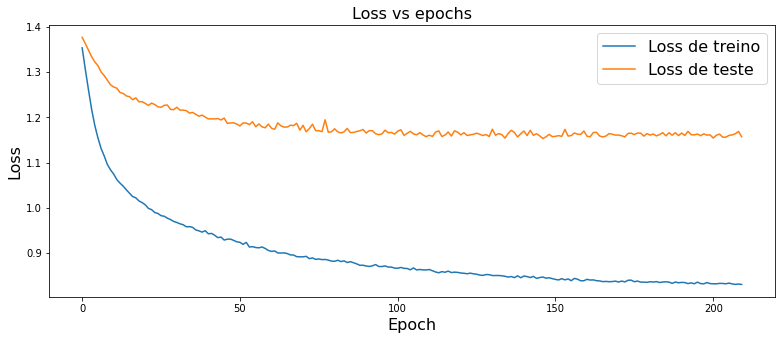

In [ ]:
grafico_de_loss = {'Loss de treino':losses_treino,
                  'Loss de teste':losses_teste}
plot_loss(grafico_de_loss)

In [ ]:
matriz = evaluate_accuracy(model, loader_teste, categorias)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Precisão da classe Glioma: 35.00 %
Precisão da classe Meningioma: 36.00 %
Precisão da classe Hipófise: 71.00 %
Precisão da classe Saudável: 92.00 %
Acurácia geral: 58.50


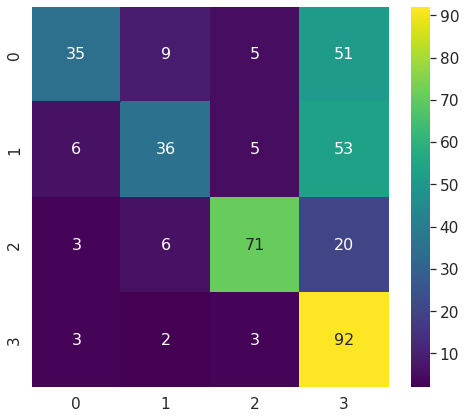

In [ ]:
plt.figure(figsize=(8, 7))
sns.set(font_scale=1.4)
sns.heatmap(matriz.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d', cmap='viridis')